In [41]:
# -------------------------------
# Imports
# -------------------------------
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Rectangle
import matplotlib.font_manager as fm

In [42]:
# -------------------------------
# Settings and Vars
# -------------------------------
csv_path = "Data/olympics.csv"
save_png  = "Output/judo_DominikDierberger.png"
save_svg  = "Output/judo_DominikDierberger.svg"
save_pdf  = "Output/judo_DominikDierberger.pdf"
os.makedirs("Output", exist_ok=True)


FONTS_DIR = "fonts_dl"


FONT_FILES = {
    "Oswald": [os.path.join(FONTS_DIR, "Oswald-Regular.ttf")],
    "Merriweather Sans": [os.path.join(FONTS_DIR, "MerriweatherSans-Regular.ttf")],
    "Noto Sans": [os.path.join(FONTS_DIR, "NotoSans-Regular.ttf")],
    "Shadows Into Light": [os.path.join(FONTS_DIR, "ShadowsIntoLight-Regular.ttf")],
}

def register_font(family, paths, fallback="DejaVu Sans"):
    for p in paths:
        if os.path.exists(p):
            try:
                fm.fontManager.addfont(p)
                print(f"✓ Registered {family} → {os.path.basename(p)}")
                return family
            except Exception as e:
                print(f"Couldn’t register {p}: {e}", file=sys.stderr)
    print(f"↪ Using fallback for {family}: {fallback}")
    return fallback


TITLE_FONT    = register_font("Oswald",              FONT_FILES["Oswald"])
SUBTITLE_FONT = register_font("Merriweather Sans",   FONT_FILES["Merriweather Sans"])
TEXT_FONT     = SUBTITLE_FONT
LABEL_FONT =    register_font("Noto Sans",           FONT_FILES["Noto Sans"])
NOTE_FONT     = register_font("Shadows Into Light",  FONT_FILES["Shadows Into Light"])

# Colors
COLOR_TITLE = "#000000"
COLOR_LABEL = "#706D63"
COLOR_TICK  = "#706D63"
COLOR_NOTE  = "#333333"

# Background
bg = "#F8F6EA"
plt.rcParams.update({
    "figure.facecolor": bg,
    "axes.facecolor":   bg,
    "savefig.facecolor":bg,
    "font.size": 11,
})
sns.set_theme(style="white", rc={"axes.facecolor": bg})

✓ Registered Oswald → Oswald-Regular.ttf
✓ Registered Merriweather Sans → MerriweatherSans-Regular.ttf
✓ Registered Noto Sans → NotoSans-Regular.ttf
✓ Registered Shadows Into Light → ShadowsIntoLight-Regular.ttf


In [43]:
# =========================================
# Tables and Data
# =========================================
import numpy as np
import pandas as pd
countries = [
    "Japan","France","South Korea","Cuba","Soviet Union",
    "Netherlands","China","Brazil","Germany","Great Britain"
]
years = [1964,1968,1972,1976,1980,1984,1988,1992,1996,2000,2004,2008,2012,2016]

ol = pd.read_csv(csv_path)

def pick_col(df, candidates, required=True):
    cols = {c.lower(): c for c in df.columns}
    for cand in candidates:
        c = cols.get(cand.lower())
        if c is not None:
            return c
    if required:
        raise KeyError(f"None of these columns found: {candidates}")
    return None

# Columns
season_col = pick_col(ol, ["Season"], required=False)
games_col  = pick_col(ol, ["Games","Edition"], required=False)
sport_col  = pick_col(ol, ["Sport","Discipline","Sport_Name","sport"])
medal_col  = pick_col(ol, ["Medal","medal","Medal_Type","medal_type"])
event_col  = pick_col(ol, ["Event","event","Event_Name"], required=False)
sex_col    = pick_col(ol, ["Sex","Gender","gender","sex","Event_gender"], required=False)
team_col   = pick_col(ol, ["Team","Country","Country_Name","region","Nation","Team/NOC"])
noc_col    = pick_col(ol, ["NOC","noc","Code","Country_Code"], required=False)
year_col   = pick_col(ol, ["Year","year","Edition_Year"])

# Filters
if season_col is not None:
    mask_summer = ol[season_col].astype(str).str.contains("Summer", case=False, na=False)
elif games_col is not None:
    mask_summer = ol[games_col].astype(str).str.contains("Summer", case=False, na=False)
else:
    mask_summer = pd.Series(True, index=ol.index)

mask_judo  = ol[sport_col].astype(str).str.lower().eq("judo")
mask_year  = ol[year_col].isin(years)
mask_medal = ol[medal_col].astype(str).isin(["Gold","Silver","Bronze"])

ol = ol[mask_summer & mask_judo & mask_year & mask_medal].copy()

TEAM_ALIASES = {
    "great britain":"Great Britain",
    "united kingdom":"Great Britain",
    "team gb":"Great Britain",

    "netherlands":"Netherlands",
    "the netherlands":"Netherlands",
    "holland":"Netherlands",

    "germany":"Germany",
    "west germany":"Germany",
    "east germany":"Germany",
    "united team of germany":"Germany",

    "republic of korea":"South Korea",
    "south korea":"South Korea",
    "korea, south":"South Korea",
    "korea":"South Korea",

    "china":"China",
    "people's republic of china":"China",
    "pr china":"China",

    "brazil":"Brazil",
    "brasil":"Brazil",
    "france":"France",
    "japan":"Japan",
    "cuba":"Cuba",
    "soviet union":"Soviet Union",
}

NOC_TO_TARGET = {
    "JPN":"Japan", "FRA":"France", "KOR":"South Korea", "CUB":"Cuba",
    "URS":"Soviet Union", "NED":"Netherlands", "CHN":"China", "BRA":"Brazil",
    "GER":"Germany", "GBR":"Great Britain",
    "FRG":"Germany", "GDR":"Germany", "EUA":"Germany", "EUN":"Soviet Union",
}

def to_bucket(team, noc):
    t = (str(team).strip().lower()) if pd.notna(team) else ""
    if t in TEAM_ALIASES:
        return TEAM_ALIASES[t]
    if pd.notna(noc):
        n = str(noc).strip().upper()
        if n in NOC_TO_TARGET:
            return NOC_TO_TARGET[n]
    return None

ol["Country"] = ol.apply(lambda r: to_bucket(r.get(team_col), r.get(noc_col) if noc_col else None),
                         axis=1)

ol = ol[ol["Country"].isin(countries)].copy()

def gender_from_event(ev):
    s = str(ev) if pd.notna(ev) else ""
    if ("Women's" in s) or ("Women’s" in s) or ("Women's " in s) or ("Women " in s):
        return "Women"
    if ("Men's" in s) or ("Men’s" in s) or ("Men's " in s) or ("Men " in s):
        return "Men"
    return np.nan

if event_col is not None:
    ol["Gender"] = ol[event_col].map(gender_from_event)
    if sex_col is not None:
        na_mask = ol["Gender"].isna()
        ol.loc[na_mask, "Gender"] = ol.loc[na_mask, sex_col].map(
            lambda x: "Men" if str(x).strip().upper() in {"M","MEN","MALE"}
            else ("Women" if str(x).strip().upper() in {"F","W","WOMEN","FEMALE"} else np.nan)
        )
else:
    if sex_col is None:
        raise KeyError("No Event or Sex column to derive Gender.")
    ol["Gender"] = ol[sex_col].map(
        lambda x: "Men" if str(x).strip().upper() in {"M","MEN","MALE"}
        else ("Women" if str(x).strip().upper() in {"F","W","WOMEN","FEMALE"} else np.nan)
    )

g = (ol.groupby(["Country", year_col, "Gender"], as_index=False)
       .size()
       .rename(columns={"size":"MedalCount", year_col:"Year"}))

idx = pd.MultiIndex.from_product([countries, years, ["Men","Women"]],
                                 names=["Country","Year","Gender"])
g = g.set_index(["Country","Year","Gender"]).reindex(idx).reset_index()

men = (g[g["Gender"]=="Men"]
       .pivot(index="Country", columns="Year", values="MedalCount")
       .reindex(index=countries, columns=years))

women = (g[g["Gender"]=="Women"]
         .pivot(index="Country", columns="Year", values="MedalCount")
         .reindex(index=countries, columns=years))

men = men.fillna(0)
women = women.fillna(0)

men.loc[:, 1968] = np.nan

for y in [y for y in years if y < 1992]:
    women.loc[:, y] = np.nan

men   = men.clip(lower=0, upper=7)
women = women.clip(lower=0, upper=7)


In [44]:
# -------------------------------
# Colors
# -------------------------------
palette = [
    "#F8F6EA",  # 0
    "#CFF2E8",  # 1
    "#ABFAE1",  # 2
    "#92ECD1",  # 3
    "#7FD8BE",  # 4
    "#CED6AC",  # 5
    "#FCCC97",  # 6
    "#FDB675",  # 7
]
cmap = ListedColormap(palette)
norm = BoundaryNorm(range(0, 9), cmap.N)

def yr_ticks(yrs): return [f"’{str(y)[-2:]}" for y in yrs]

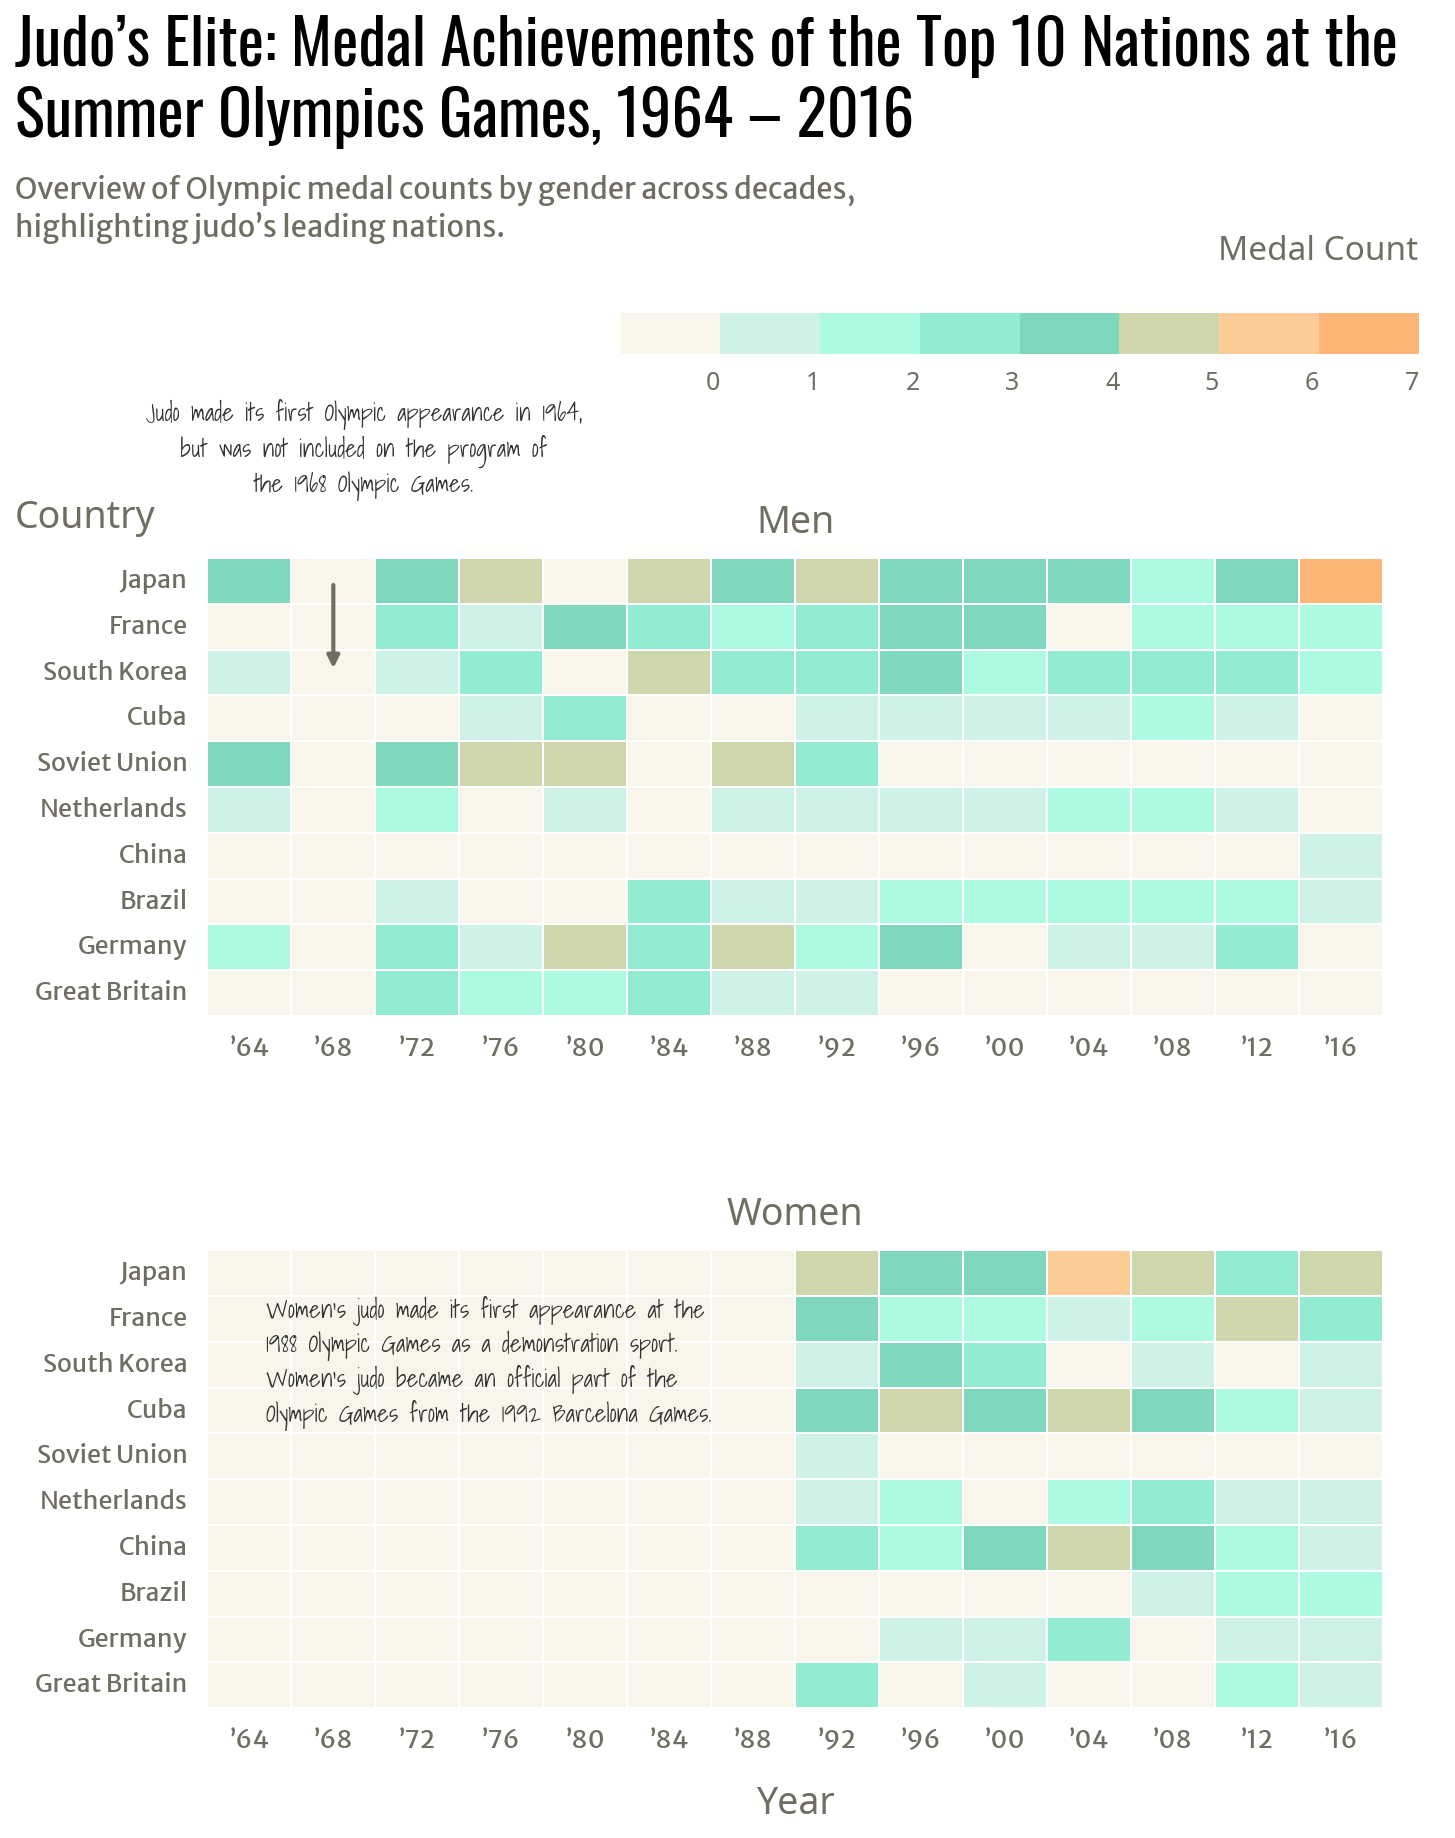

In [45]:
# -------------------------------
# Figure
# -------------------------------
fig = plt.figure(figsize=(9.5, 14.2), dpi=150)

# Title
fig.text(
    0.00, 0.965,
    "Judo’s Elite: Medal Achievements of the Top 10 Nations at the\n"
    "Summer Olympics Games, 1964 – 2016",
    ha="left", va="top",
    fontsize=30, weight="bold", fontfamily=TITLE_FONT, color=COLOR_TITLE, linespacing=1.15
)

# Subtitle
fig.text(
    0.00, 0.89,
    "Overview of Olympic medal counts by gender across decades,\n"
    "highlighting judo’s leading nations.",
    ha="left", va="top",
    fontsize=14, fontfamily=SUBTITLE_FONT, color=COLOR_LABEL
)

# ── Legend
leg_ax = fig.add_axes([0.00, 0.785, 1.00, 0.08])
leg_ax.axis("off")

# Legend title (right aligned, below subtitle)
leg_ax.text(0.985, 0.86, "Medal Count", ha="right", va="center",
            fontsize=16, weight="bold", fontfamily=LABEL_FONT, color=COLOR_LABEL)

# Boxes
n = 8
box_w, gap, y, h = 0.070, 0.000, 0.26, 0.24
total_w = n*box_w + (n-1)*gap
right_pad = 0.015
start_x = 1.0 - right_pad - total_w

for i in range(n):
    x = start_x + i*(box_w + gap)
    # color box
    leg_ax.add_patch(Rectangle((x, y), box_w, h,
                               facecolor=cmap(i/7), edgecolor="none",
                               transform=leg_ax.transAxes))
    leg_ax.text(x + box_w -0.01, y -0.17, f"{i}",
                ha="left", va="center", fontsize=12,
                fontfamily=LABEL_FONT, weight="bold", color=COLOR_LABEL)

# Men note
fig.text(
    0.245, 0.785,
    "Judo made its first Olympic appearance in 1964,\n"
    "but was not included on the program of\n"
    "the 1968 Olympic Games.",
    ha="center", va="top",
    fontsize=12, fontfamily=NOTE_FONT, color=COLOR_NOTE
)

# Color for NaN cells
try:
    cmap.set_bad(bg)
except Exception:
    pass

# Men heatmap
ax_men = fig.add_axes([0.135, 0.495, 0.825, 0.215])
sns.heatmap(
    men, ax=ax_men, cmap=cmap, vmin=0, vmax=7, cbar=False,
    linewidths=0.9, linecolor="#FFFFFF", square=False
)
ax_men.set_title("Men", loc="center", pad=12,
                 fontsize=18, weight="bold", fontfamily=LABEL_FONT, color=COLOR_LABEL)
ax_men.set_yticklabels(ax_men.get_yticklabels(), rotation=0,
                       fontfamily=TEXT_FONT, fontsize=12, color=COLOR_TICK)
ax_men.set_xticklabels(yr_ticks(years),
                       fontfamily=TEXT_FONT, fontsize=12, color=COLOR_TICK)
ax_men.grid(False)
for s in ax_men.spines.values(): s.set_visible(False)
ax_men.set_xlabel(""); ax_men.set_ylabel("")

fig.text(0.00, 0.72, "Country",
         ha="left", va="bottom",
         fontsize=18, weight="bold", fontfamily=LABEL_FONT, color=COLOR_LABEL)

# arrow
col_1968 = men.columns.get_loc(1968)
x1968 = col_1968 + 0.5
r_jpn = men.index.get_loc("Japan") + 0.5
r_kor = men.index.get_loc("South Korea") + 0.5
ax_men.annotate(
    "",
    xy=(x1968, r_kor), xytext=(x1968, r_jpn),
    xycoords="data", textcoords="data",
    arrowprops=dict(arrowstyle="-|>", lw=2, color=COLOR_LABEL),
    zorder=5, clip_on=False
)

# Women heatmap
ax_women = fig.add_axes([0.135, 0.170, 0.825, 0.215])
sns.heatmap(
    women, ax=ax_women, cmap=cmap, vmin=0, vmax=7, cbar=False,
    linewidths=0.9, linecolor="#FFFFFF", square=False
)
ax_women.set_title("Women", loc="center", pad=12,
                   fontsize=18, weight="bold", fontfamily=LABEL_FONT, color=COLOR_LABEL)
ax_women.set_yticklabels(ax_women.get_yticklabels(), rotation=0,
                         fontfamily=TEXT_FONT, fontsize=12, color=COLOR_TICK)
ax_women.set_xticklabels(yr_ticks(years),
                         fontfamily=TEXT_FONT, fontsize=12, color=COLOR_TICK)
ax_women.grid(False)
for s in ax_women.spines.values(): s.set_visible(False)
ax_women.set_xlabel(""); ax_women.set_ylabel("")

# Women note
ax_women.text(
    0.05, 0.90,
    "Women’s judo made its first appearance at the \n"
    "1988 Olympic Games as a demonstration sport.\n"
    "Women’s judo became an official part of the\n"
    "Olympic Games from the 1992 Barcelona Games.",
    transform=ax_women.transAxes, ha="left", va="top",
    fontsize=12, fontfamily=NOTE_FONT, color=COLOR_NOTE
)

# Year
wpos = ax_women.get_position()
fig.text((wpos.x0 + wpos.x1)/2, wpos.y0 - 0.045,
         "Year", ha="center", va="center",
         fontsize=18, weight="bold", fontfamily=LABEL_FONT, color=COLOR_LABEL)

# Save
fig.savefig(save_png, dpi=300, bbox_inches="tight")
fig.savefig(save_svg, dpi=300, bbox_inches="tight")
fig.savefig(save_pdf, dpi=300, bbox_inches="tight")
plt.show()
